In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

In [ ]:
const QC = QControl;

In [ ]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

In [ ]:
# using PyCall;
# only needed once
# using Conda;
# Conda.add("qutip");
# Conda.add("imageio");

# Set up Dynamics

In [ ]:
"""
Here, we use the following augmented state and augmented controls choice, and optimizer params.

```
astate = [ψ_state, controls]
acontrol = [d(controls)]
```
where `controls = [uᵣ₁, uᵢ₁]`

This augmented state and control technique is based on work 
in Propson, T. et al. Physical Review Applied 17 (2022).
"""
params = Dict()
params["basis"] = SpinBasis(1//2)
params["H₀"] = 2*π*.01*dm(spinup(params["basis"]))
params["Hcs"] = [sigmax(bq_single)/2]
params["ψi"] = [spinup(bq_single)]
params["ψt"] = [-spinup(bq_single)]
params["N"] = 1001
params["tf"] = 5.0
params["dt"] = params["tf"]/(params["N"] - 1)
params["dt_acontrol"] = params["tf"]/(params["N"] - 2)
params["cost_scale"] = 0.0001
params["control_norm_bound"] = 2.5
params["control_derivative_range"] = (0,1)
;

LoadError: UndefVarError: bq_single not defined

In [ ]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, astate_initial, astate_target = QC.gen_LQR_params(params["basis"], params["H₀"], params["Hcs"], params["ψi"], params["ψt"], control_derivative_range=params["control_derivative_range"])
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

LoadError: KeyError: key "Hcs" not found

In [ ]:
model = QC.QuantumState();
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)
;

LoadError: NotImplementedError: state_dim needs to be implemented for QuantumState{0}.

In [129]:
Q, R = gen_default_QR(state_dim, control_dim; N=N, tf=tf, amp_scale=amp_scale, control_derivative_range=control_derivative_range)
Q

6×6 Diagonal{Float64, Vector{Float64}}:
 0.0   ⋅    ⋅    ⋅    ⋅       ⋅ 
  ⋅   0.0   ⋅    ⋅    ⋅       ⋅ 
  ⋅    ⋅   0.0   ⋅    ⋅       ⋅ 
  ⋅    ⋅    ⋅   0.0   ⋅       ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0e-7   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅      1.0e-7

In [130]:
R

2×2 Matrix{Float64}:
 1.0e-7  -0.0
 0.0      1.0e-7

In [131]:
obj = gen_default_objective(state_dim, control_dim, astate_target; N=N, tf=tf, amp_scale=amp_scale, control_derivative_range=control_derivative_range)

Objective

In [132]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
# normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
# add_constraint!(cons, normcon, N)


# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

control_norm_cons = NormConstraint(state_dim, control_dim, control_norm_bound, Inequality(), [5,6])
add_constraint!(cons, control_norm_cons, 1:N)

goalcon = GoalConstraint(astate_target)
add_constraint!(cons, goalcon, N)

In [133]:
prob = Problem(model, obj, astate_initial, tf, xf=astate_target, integration=RD.RK4(model), constraints=cons);

In [134]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [135]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8
opts.max_cost_value = 1e20

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [136]:
solve!(solver);

In [137]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [138]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 1
Final cost: NaN
Final constraint satisfaction: NaN


# Save Data

In [90]:
# save data (uncomment to save)
save_solver_data(solver, label="data/cz_pulse_derivative_constraint_tf_100_control_bound_0p01")

In [91]:
# load data
data = load_solver_data("data/cz_pulse_derivative_constraint_tf_100_control_bound_0p01.jld2")

Dict{String, Vector} with 2 entries:
  "acontrols" => SVector{2, Float64}[[NaN, NaN], [0.493784, 0.221491], [0.63222…
  "astates"   => SVector{6, Float64}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [NaN, NaN,…

# Parse Data

In [92]:
astates = data["astates"]
acontrols = data["acontrols"]
Xqv = states_to_kets(map(astate -> astate[1:4], astates), bq_single)
# iUcv = controls_to_amplitudes(map(astate -> astate[5:6], astates))
Ucv = controls_to_amplitudes(map(astate -> astate[5:6], astates))
# dUcv = controls_to_amplitudes(map(astate -> astate[7:8], astates))
# ddUcv = controls_to_amplitudes(acontrols)
dUcv = controls_to_amplitudes(acontrols)
ts = dt*(1:N)
;

# Analyze States

In [93]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
 1.0 + 0.0im
 0.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 NaN + NaN*im
 NaN + NaN*im


In [94]:
# szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);
r1t = map(qv -> real(qv.data[1]), Xqv);
i1t = map(qv -> imag(qv.data[1]), Xqv);
leakaget = map(qv -> abs(qv.data[2]), Xqv);

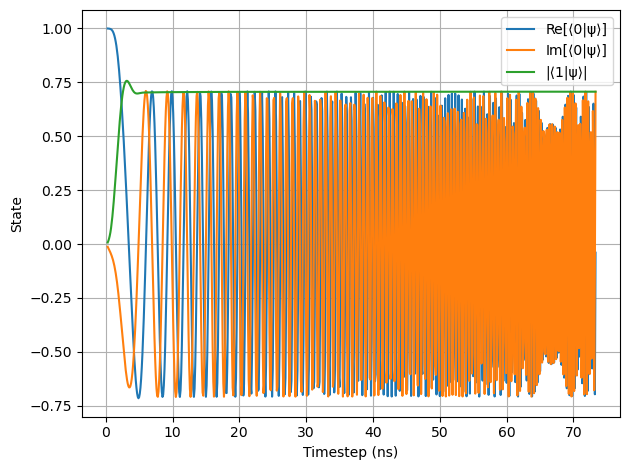

In [95]:
ts = 1:N
plot(dt*ts, r1t, label="Re[⟨0|ψ⟩]")
plot(dt*ts, i1t, label="Im[⟨0|ψ⟩]")
plot(dt*ts, leakaget, label="|⟨1|ψ⟩|")
xlabel("Timestep (ns)")
ylabel("State")
grid("on")
legend()
tight_layout()

In [96]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

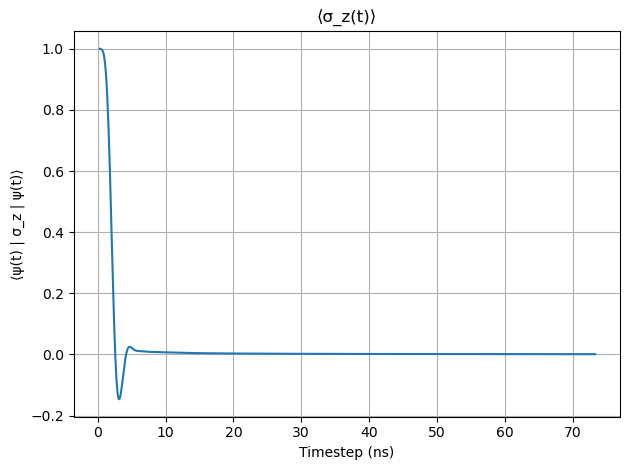

In [97]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

# Analyze Controls

In [98]:
function plot_control(controls, ts; label::String="u", index::Int = 1)    
    Ucv = map(cv -> cv[index], controls)
    Urv = map(cv -> real(cv), Ucv)
    Uiv = map(cv -> imag(cv), Ucv)
    Uav = map(cv -> norm(cv), Ucv)
    figure()
    plot(ts, Urv, label=string("Re[", label,"(t)]"))
    plot(ts, Uiv, label=string("Im[", label,"(t)]"))
    plot(ts, Uav, label=string("|", label,"(t)|"))
    xlabel("Timestep (ns)")
    ylabel(string(label, "(t)"))
    legend()
    grid("on")
    tight_layout()
end

plot_control (generic function with 1 method)

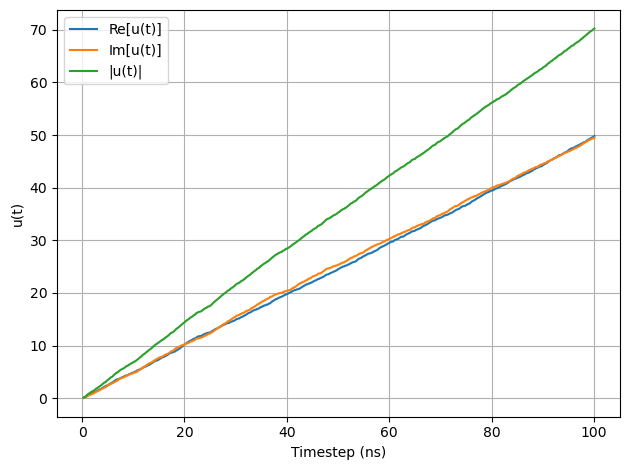

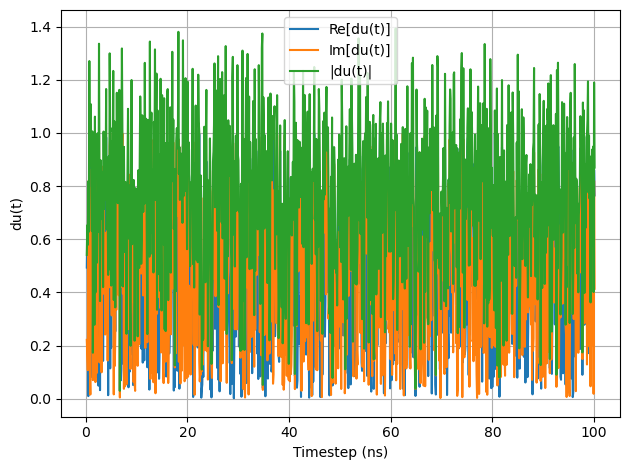

In [99]:
dt_control = dt*N/(N-1)
plot_control(Ucv, (1:N)*dt, label="u")
plot_control(dUcv, (1:N-1)*dt_control, label="du")

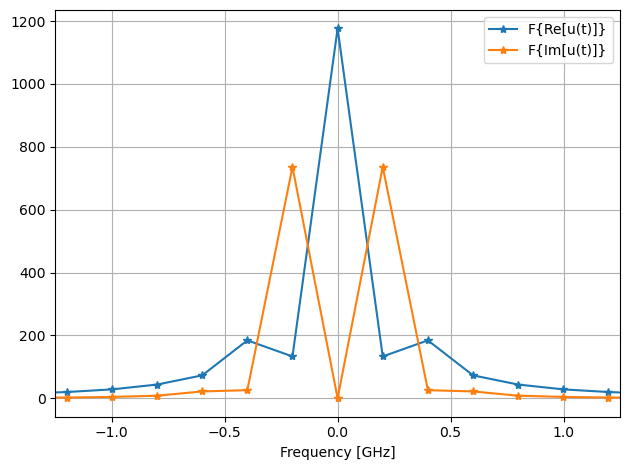

In [52]:
plot_fft(map(cv -> cv[1], Ucv), dt, tf, xlim=(-1.25,1.25))

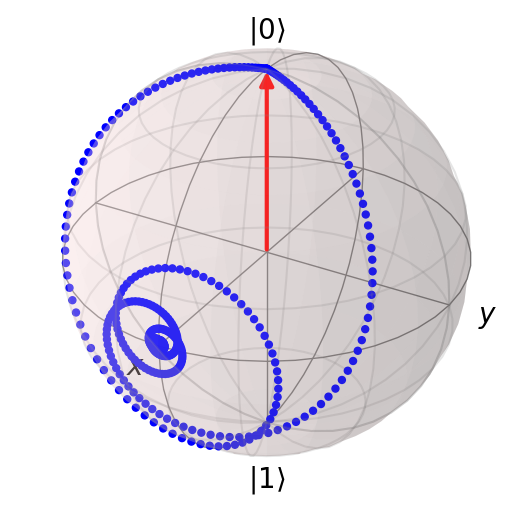

PyObject <qutip.bloch.Bloch object at 0x1db5005e0>

In [ ]:
animate_bloch(Xqv[1:2:end], duration=0.03, save_all=true)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)